In [13]:
import pandas as pd
import numpy as np
import plotly.express as px
from pathlib import Path

import plotly.io as pio
pio.renderers.default = "notebook"

import matplotlib.pyplot as plt

# IBTrACS

In [14]:
def clean_basin(b):
    if isinstance(b, bytes):
        return b.decode("utf-8")
    if isinstance(b, str) and b.startswith("b'"):
        return b[2:-1]
    return b

def load_IBTrACS(path, years):
    df = pd.read_csv(path)
    df["time_stamp"] = pd.to_datetime(df["time_stamp"], errors="coerce")
    df = df.dropna(subset=["time_stamp"])
    df["basin"] = df["basin"].apply(clean_basin)
    df = df[
        (df["time_stamp"].dt.year >= years[0]) &
        (df["time_stamp"].dt.year <= years[1])
    ]
    print(
        "IBTrACS:",
        df["time_stamp"].dt.year.min(), "→", df["time_stamp"].dt.year.max(),
        "| obs:", len(df),
        "| cyclones:", df["sid"].nunique()
    )
    return df

IBTrACS: 2022 → 2024 | obs: 15365 | cyclones: 277


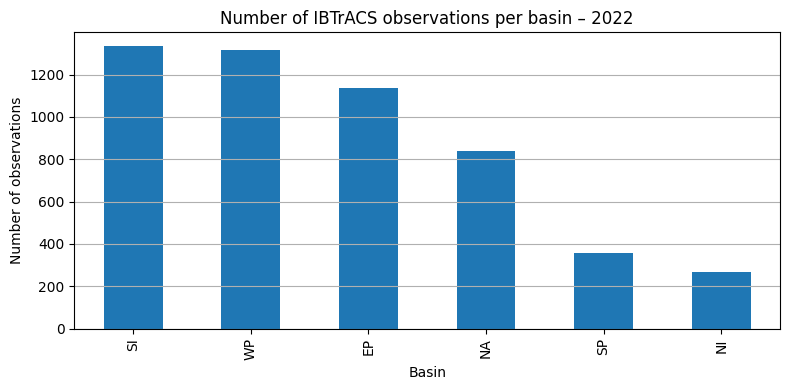

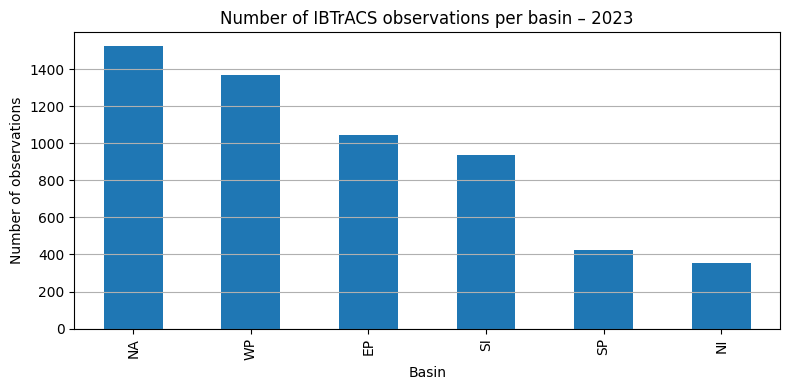

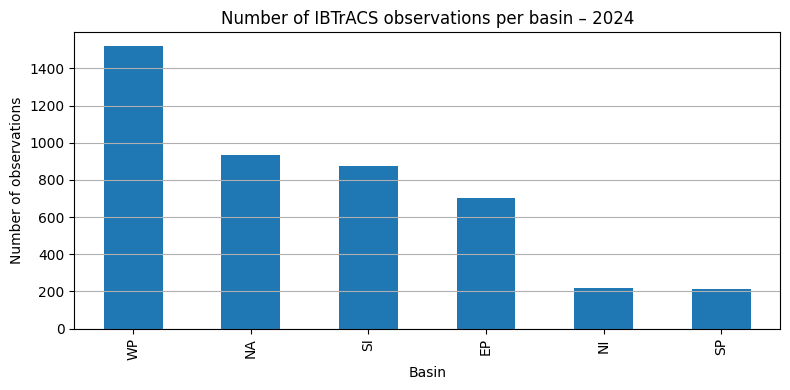

In [15]:
PROCESSED_DIR = Path("../../data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

path_ibtracs = PROCESSED_DIR / "other/ibtracs_usa_20251216.csv"

df_ibtracs = load_IBTrACS(path_ibtracs, years=[2022, 2024])

df_ibtracs["time_stamp"] = pd.to_datetime(df_ibtracs["time_stamp"], errors="coerce")
df_ibtracs = df_ibtracs.dropna(subset=["time_stamp"])

years = sorted(df_ibtracs["time_stamp"].dt.year.unique())

for year in years:
    df_y = df_ibtracs[df_ibtracs["time_stamp"].dt.year == year]

    counts = (
        df_y.groupby("basin")
        .size()
        .sort_values(ascending=False)
    )

    plt.figure(figsize=(8, 4))
    counts.plot(kind="bar")
    plt.title(f"Number of IBTrACS observations per basin – {year}")
    plt.ylabel("Number of observations")
    plt.xlabel("Basin")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()


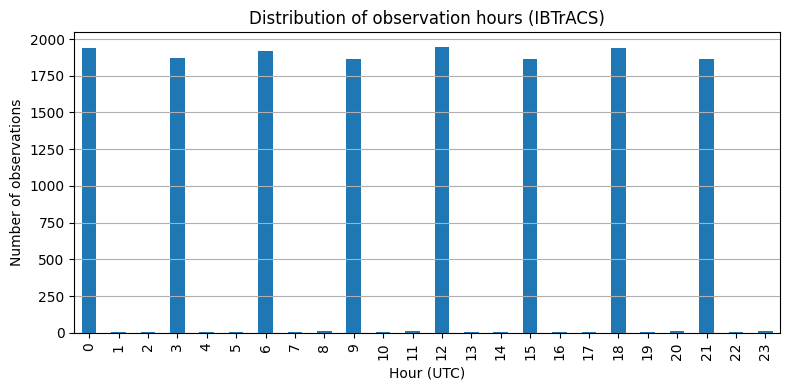

In [16]:
hour_counts = (
    df_ibtracs["time_stamp"]
    .dt.hour
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(8, 4))
hour_counts.plot(kind="bar")
plt.xlabel("Hour (UTC)")
plt.ylabel("Number of observations")
plt.title("Distribution of observation hours (IBTrACS)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

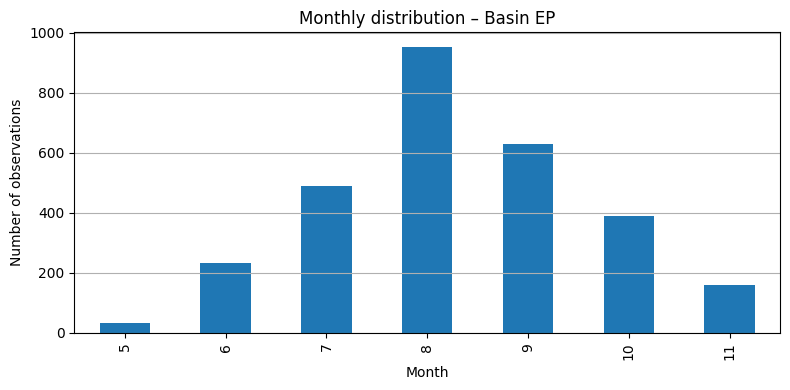

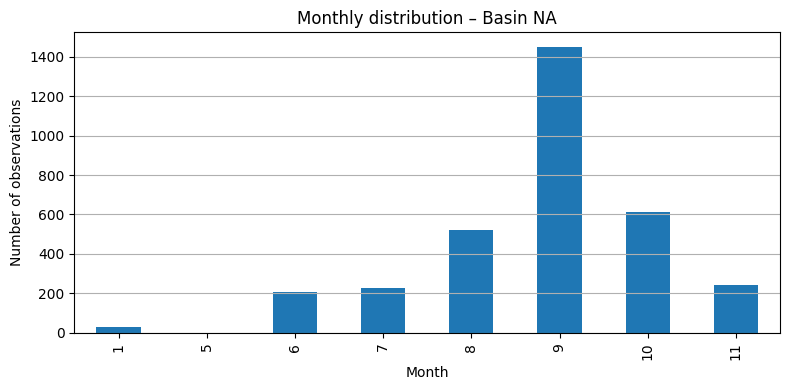

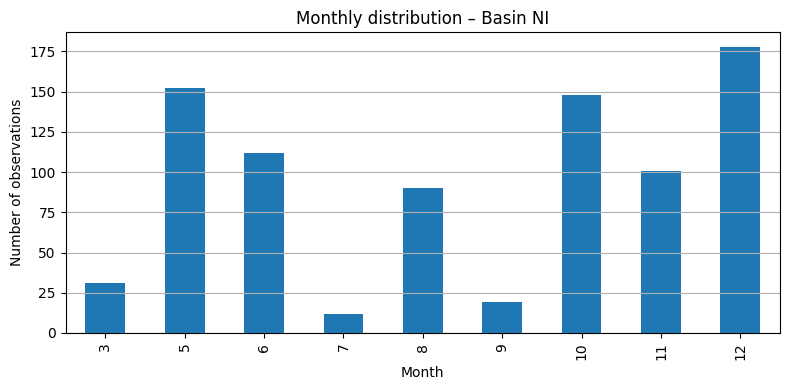

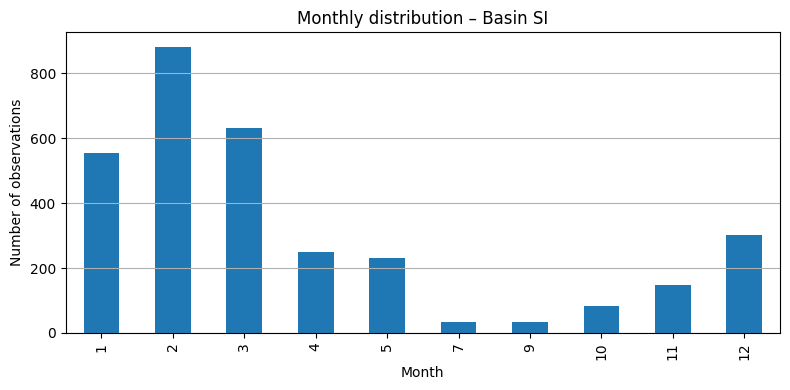

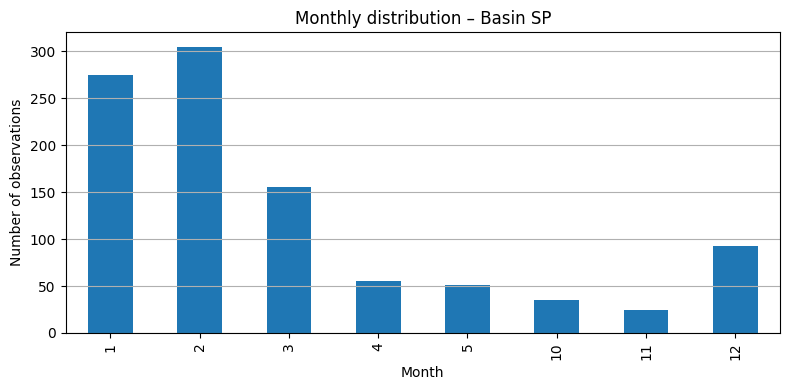

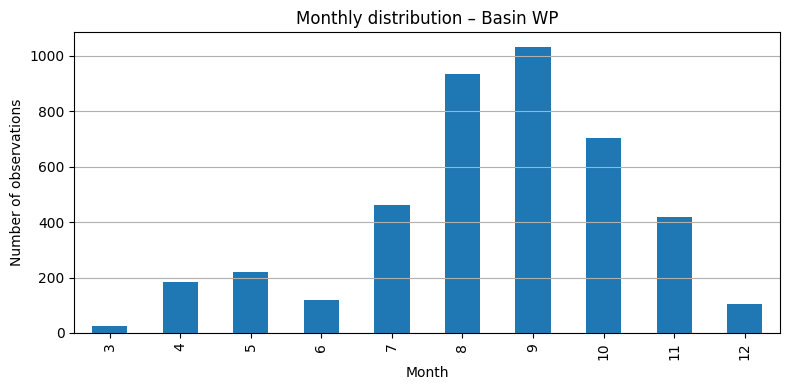

In [17]:
basins = sorted(df_ibtracs["basin"].unique())

for basin in basins:
    df_b = df_ibtracs[df_ibtracs["basin"] == basin]

    month_counts = (
        df_b["time_stamp"]
        .dt.month
        .value_counts()
        .sort_index()
    )

    plt.figure(figsize=(8, 4))
    month_counts.plot(kind="bar")
    plt.xlabel("Month")
    plt.ylabel("Number of observations")
    plt.title(f"Monthly distribution – Basin {basin}")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()


In [18]:
df_ibtracs

,date_time,sid,name,season,basin,lat,lon,wind,pressure,storm_speed,storm_dir,time_stamp,year,month,day,hour
4752,56,b'2024359S13097',b'UNNAMED',2025.0,SI,-17.5,90.1,19.0,1007.0,10.0,255.0,2024-12-31 00:00:00.000039936,2024,12,31,0
4753,55,b'2024359S13097',b'UNNAMED',2025.0,SI,-17.4,90.6,22.0,1007.0,10.0,255.0,2024-12-30 21:00:00.000039936,2024,12,30,21
4754,54,b'2024359S13097',b'UNNAMED',2025.0,SI,-17.3,91.1,25.0,1006.0,11.0,265.0,2024-12-30 18:00:00.000039936,2024,12,30,18
4755,53,b'2024359S13097',b'UNNAMED',2025.0,SI,-17.3,91.8,25.0,1006.0,12.0,265.0,2024-12-30 15:00:00.000039936,2024,12,30,15
4756,52,b'2024359S13097',b'UNNAMED',2025.0,SI,-17.3,92.4,25.0,1005.0,10.0,265.0,2024-12-30 12:00:00.000039936,2024,12,30,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20112,72,b'2021358S09130',b'SETH',2022.0,SP,-22.1,158.3,35.0,1000.0,12.0,150.0,2022-01-01 12:00:00.000039936,2022,1,1,12
20113,71,b'2021358S09130',b'SETH',2022.0,SP,-21.8,157.9,38.0,998.0,11.0,135.0,2022-01-01 09:00:00.000039936,2022,1,1,9
20114,70,b'2021358S09130',b'SETH',2022.0,SP,-21.7,157.4,40.0,996.0,9.0,125.0,2022-01-01 06:00:00.000039936,2022,1,1,6
20115,69,b'2021358S09130',b'SETH',2022.0,SP,-21.5,157.0,40.0,997.0,8.0,120.0,2022-01-01 03:00:00.000039936,2022,1,1,3


# Bouding Box

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime 

BASIN_BBOX = {
    "NA": [60, -100, 0, -10],
    "EP": [40, -160, 0, -80],
    "WP": [50, 100, 0, 180],
    "NI": [30, 40, 0, 100],
    "SI": [0, 20, -40, 100],
    "SP": [0, 160, -40, -120],
}

BASIN_COLORS = {
    "NA": "#1f77b4",  
    "EP": "#ff7f0e",  
    "WP": "#2ca02c",  
    "NI": "#d62728",  
    "SI": "#9467bd",  
    "SP": "#8c564b",  
    "SA": "#e377c2",  
}


def plot_basin_bounding_boxes_with_template(basin_bbox_dict, basin_colors):
    """
    Plot cyclone basin bounding boxes on a world map.
    Correctly handles basins crossing the anti-meridian (±180°).
    """

    # Dummy dataframe just to initialize the geo figure
    df_dummy = pd.DataFrame({
        "lon": [0],
        "lat": [0],
    })

    fig = px.line_geo(
        df_dummy,
        lon="lon",
        lat="lat",
        projection="natural earth",
        title="Cyclone basin bounding boxes",
    )

    # Remove dummy trace
    fig.data = []

    for basin, bbox in basin_bbox_dict.items():
        north, west, south, east = bbox
        color = basin_colors.get(basin, "black")

        # --- Handle anti-meridian crossing ---
        if west <= east:
            # Normal case
            lon_segments = [(west, east)]
        else:
            # Anti-meridian case (e.g. SP)
            lon_segments = [
                (west, 180),
                (-180, east),
            ]

        for i, (w, e) in enumerate(lon_segments):
            lats = [south, north, north, south, south]
            lons = [w, w, e, e, w]

            fig.add_trace(
                go.Scattergeo(
                    lon=lons,
                    lat=lats,
                    mode="lines",
                    line=dict(width=2, color=color),
                    name=basin,
                    showlegend=(i == 0),  # avoid legend duplicates
                    hoverinfo="text",
                    text=(
                        f"Basin {basin}<br>"
                        f"N: {north}°<br>"
                        f"S: {south}°<br>"
                        f"W: {west}°<br>"
                        f"E: {east}°"
                    ),
                )
            )

        # --- Basin label ---
        if west <= east:
            label_lon = (west + east) / 2
        else:
            # Place label safely inside visible region
            label_lon = 170

        label_lat = (north + south) / 2

        fig.add_trace(
            go.Scattergeo(
                lon=[label_lon],
                lat=[label_lat],
                mode="text",
                text=[basin],
                textfont=dict(color=color, size=12),
                showlegend=False,
            )
        )

    fig.update_layout(
        legend_title_text="Basin",
        margin=dict(l=0, r=0, t=40, b=0),
        hovermode="closest",
    )

    fig.show()


plot_basin_bounding_boxes_with_template(BASIN_BBOX, BASIN_COLORS)

# ERA5

In [32]:
# Paths
PATH = "../../data/processed/ibtracs_era5_20251217_1724.csv"

# Load data
df = pd.read_csv(PATH, parse_dates=["Timestamp"])

print("Dataset shape:", df.shape)
print("Years:", sorted(df["Timestamp"].dt.year.unique()))

df

Dataset shape: (14192, 19)
Years: [np.int32(2022), np.int32(2023), np.int32(2024)]


,Storm_ID,Storm_Name,Ocean_Basin,Year,Timestamp,number,Latitude,Longitude,Observed_Wind_Max_Knots,Observed_Pressure_Min_mb,Storm_Speed_Knots,Storm_Direction_Deg,ERA5_Temp_2m_Kelvin,ERA5_Pressure_MSL_hPa,ERA5_Wind_U_Component,ERA5_Wind_V_Component,ERA5_Position_Error_km,latitude,longitude
0,b'2022008S17173',b'CODY',SP,2022.0,2022-01-07 12:00:00.000039936,2.0,-17.4,172.8,25.0,1004.0,3.0,205.0,300.53052,1002.84686,2.650101,-8.584717,23.952900,-17.5,173.0
1,b'2022008S17173',b'CODY',SP,2022.0,2022-01-07 15:00:00.000039936,2.0,-17.5,172.7,25.0,1004.0,3.0,200.0,299.83300,1000.66500,5.834000,5.967590,21.209696,-17.5,172.5
2,b'2022008S17173',b'CODY',SP,2022.0,2022-01-07 18:00:00.000039936,2.0,-17.7,172.7,25.0,1004.0,3.0,180.0,299.82715,1001.25940,9.274033,2.420151,30.723391,-17.5,172.5
3,b'2022008S17173',b'CODY',SP,2022.0,2022-01-07 21:00:00.000039936,2.0,-18.0,172.7,30.0,1001.0,4.0,160.0,300.29175,1001.53625,0.749100,4.640472,21.150531,-18.0,172.5
4,b'2022008S17173',b'CODY',SP,2022.0,2022-01-08 00:00:00.000039936,2.0,-18.2,172.8,35.0,997.0,3.0,135.0,300.49487,1001.75810,6.010010,-8.911682,30.682377,-18.0,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14187,b'2024359S13097',b'UNNAMED',SI,2025.0,2024-12-30 12:00:00.000039936,103.0,-17.3,92.4,25.0,1005.0,10.0,265.0,299.56177,1005.53625,-7.751511,1.018127,24.640588,-17.5,92.5
14188,b'2024359S13097',b'UNNAMED',SI,2025.0,2024-12-30 15:00:00.000039936,103.0,-17.3,91.8,25.0,1006.0,12.0,265.0,299.48584,1007.55630,-8.498520,1.363357,30.739502,-17.5,92.0
14189,b'2024359S13097',b'UNNAMED',SI,2025.0,2024-12-30 18:00:00.000039936,103.0,-17.3,91.1,25.0,1006.0,11.0,265.0,299.27980,1007.03436,-7.581604,3.381882,24.640588,-17.5,91.0
14190,b'2024359S13097',b'UNNAMED',SI,2025.0,2024-12-30 21:00:00.000039936,103.0,-17.4,90.6,22.0,1007.0,10.0,255.0,298.98315,1005.62620,-5.707230,2.274322,15.367749,-17.5,90.5


In [ ]:
METEO_VARS = [
    "ERA5_Temp_2m_Kelvin",
    "ERA5_Pressure_MSL_hPa",
    "ERA5_Wind_U_Component",
    "ERA5_Wind_V_Component",
]

def summarize_year(df, year):
    year = int(year)
    df_y = df[df["Timestamp"].dt.year == year]

    if df_y.empty:
        print(f"\n===== SUMMARY {year} =====")
        print("No data")
        return

    print(f"\n===== SUMMARY {year} =====")
    print("Observations:", len(df_y))
    print("Cyclones:", df_y["Storm_ID"].nunique())
    print(
        "Period:",
        df_y["Timestamp"].min(),
        "→",
        df_y["Timestamp"].max(),
    )

    print("\nObservations per cyclone:")
    print(df_y.groupby("Storm_ID").size().describe())

    print("\nMeteorological variables:")
    display(df_y[METEO_VARS].describe())

for year in sorted(df["Timestamp"].dt.year.unique()):
    summarize_year(df, year)


In [ ]:
def check_nans_year(df, year):
    df_y = df[df["Timestamp"].dt.year == year]

    print(f"\nNaN check {year}")
    if df_y.empty:
        print("No data")
        return

    print(df_y[METEO_VARS].isna().mean())


for year in sorted(df["Timestamp"].dt.year.unique()):
    check_nans_year(df, year)


In [ ]:
def plot_cyclone_tracks_year(df, year):
    df_y = (
        df[df["Timestamp"].dt.year == year]
        .sort_values("Timestamp")
        .copy()
    )

    if df_y.empty:
        print(f"No data for {year}")
        return

    fig = px.line_geo(
        df_y,
        lon="Longitude",
        lat="Latitude",
        color="Storm_ID",
        hover_name="Storm_Name",
        projection="natural earth",
        title=f"Cyclone trajectories – {year}",
    )

    fig.update_traces(
        line=dict(width=2),
        hovertemplate=
        "<b>Cyclone:</b> %{customdata[0]}<br>"
        "<b>Date:</b> %{customdata[1]}<br>"
        "<b>Lat:</b> %{lat:.2f}°<br>"
        "<b>Lon:</b> %{lon:.2f}°<br><br>"
        "<b>IBTrACS</b><br>"
        "Wind: %{customdata[2]} kt<br>"
        "Pressure: %{customdata[3]} hPa<br><br>"
        "<b>ERA5</b><br>"
        "2m Temp: %{customdata[4]:.1f} K<br>"
        "MSLP: %{customdata[5]:.1f} hPa<br>"
        "U10: %{customdata[6]:.1f} m/s<br>"
        "V10: %{customdata[7]:.1f} m/s"
        "<extra></extra>",
        customdata=df_y[[
            "Storm_Name",
            "Timestamp",
            "Observed_Wind_Max_Knots",
            "Observed_Pressure_Min_mb",
            "ERA5_Temp_2m_Kelvin",
            "ERA5_Pressure_MSL_hPa",
            "ERA5_Wind_U_Component",
            "ERA5_Wind_V_Component",
        ]].values
    )

    fig.update_layout(
        legend_title_text="Storm ID",
        margin=dict(l=0, r=0, t=40, b=0),
        hovermode="closest",
    )

    fig.show()

plot_cyclone_tracks_year(df, 2022)
plot_cyclone_tracks_year(df, 2023)
plot_cyclone_tracks_year(df, 2024)

In [ ]:
def count_ibtracs_cyclones_year(df_ibtracs, year): 
    df_y = df_ibtracs[df_ibtracs["time_stamp"].dt.year == year] 
    return df_y["sid"].nunique()

def count_era5_cyclones_year(df_era5, year):
    df_y = df_era5[df_era5["Timestamp"].dt.year == year]
    return df_y["Storm_ID"].nunique()

def count_ibtracs_obs_year(df_ibtracs, year): 
    df_y = df_ibtracs[df_ibtracs["time_stamp"].dt.year == year] 
    return len(df_y)

def count_era5_obs_year(df_era5, year):
    df_y = df_era5[df_era5["Timestamp"].dt.year == year]
    return len(df_y)


rows = []

for year in years:
    n_cyc_ib = count_ibtracs_cyclones_year(df_ibtracs, year)
    n_cyc_era = count_era5_cyclones_year(df, year)

    n_obs_ib = count_ibtracs_obs_year(df_ibtracs, year)
    n_obs_era = count_era5_obs_year(df, year)

    rows.append({
        "Year": year,
        "Cyclones_IBTrACS": n_cyc_ib,
        "Cyclones_with_ERA5": n_cyc_era,
        "Cyclone_Coverage_Ratio": (
            n_cyc_era / n_cyc_ib if n_cyc_ib > 0 else np.nan
        ),
        "Observations_IBTrACS": n_obs_ib,
        "Observations_with_ERA5": n_obs_era,
        "Observation_Coverage_Ratio": (
            n_obs_era / n_obs_ib if n_obs_ib > 0 else np.nan
        ),
    })

df_coverage_full = pd.DataFrame(rows)
df_coverage_full



In [ ]:
df.describe()

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df["ERA5_Position_Error_km"], bins=10, range=(0, 50))
plt.xlabel("ERA5 spatial error (km)")
plt.ylabel("Number of observations")
plt.title("ERA5 spatial error (50 km)")
plt.grid(True)
plt.tight_layout()
plt.show()


Un pas de grille ERA5 de 0.25° à 0.5° correspond à une résolution spatiale de l’ordre de 20 à 50 km selon la latitude, ce qui rend les erreurs spatiales observées (médiane ≈ 20 km, maximum ≈ 30 km) parfaitement cohérentes avec un échantillonnage nearest-neighbor.

In [ ]:
import pandas as pd

def check_overlaps_final_dataset(
    df,
    key_cols=("Storm_ID", "Timestamp"),
    strict_cols=("Storm_ID", "Timestamp", "Latitude", "Longitude"),
    show_examples=20,
):
    """
    Overlap = mêmes clés (Storm_ID, Timestamp) présentes plusieurs fois.
    - strict_cols permet de voir si c'est un vrai doublon (mêmes coords) ou un conflit (coords différentes).
    """
    df2 = df.copy()

    # --- 1) Doublons sur la clé principale (Storm_ID, Timestamp) ---
    dup_mask = df2.duplicated(list(key_cols), keep=False)
    df_dup = df2[dup_mask].sort_values(list(key_cols))

    print("=== Overlap check ===")
    print("Rows:", len(df2))
    print("Unique keys:", df2[list(key_cols)].drop_duplicates().shape[0])
    print("Duplicate-key rows:", len(df_dup))
    print("Duplicate keys count:", df2[list(key_cols)].duplicated().sum())

    if df_dup.empty:
        print("\nAucun overlap sur la clé", key_cols)
        return {
            "duplicate_key_rows": 0,
            "duplicate_keys": 0,
            "strict_duplicate_rows": 0,
            "conflict_keys": 0,
        }

    # --- 2) Séparer "vrais doublons" vs "conflits" ---
    # Vrai doublon = mêmes strict_cols répétés
    strict_dup_mask = df2.duplicated(list(strict_cols), keep=False)
    df_strict_dup = df2[strict_dup_mask].sort_values(list(strict_cols))

    # Conflit = même (Storm_ID, Timestamp) mais pas exactement mêmes strict_cols
    # => on regarde le nb de lignes distinctes par clé après réduction sur strict_cols
    grp = df_dup.groupby(list(key_cols))
    conflict_keys = []
    for k, g in grp:
        if g[list(strict_cols)].drop_duplicates().shape[0] > 1:
            conflict_keys.append(k)

    print("\n--- Details ---")
    print("Strict-duplicate rows (exact same Storm_ID+Timestamp+Lat+Lon):", len(df_strict_dup))
    print("Conflict keys (same Storm_ID+Timestamp but different Lat/Lon):", len(conflict_keys))

    # --- 3) Afficher exemples ---
    print("\n--- Example duplicate-key rows ---")
    display(df_dup.head(show_examples))

    if conflict_keys:
        print("\n--- Example conflict key ---")
        k0 = conflict_keys[0]
        display(df_dup[(df_dup["Storm_ID"] == k0[0]) & (df_dup["Timestamp"] == k0[1])])

    return {
        "duplicate_key_rows": int(len(df_dup)),
        "duplicate_keys": int(df2[list(key_cols)].duplicated().sum()),
        "strict_duplicate_rows": int(len(df_strict_dup)),
        "conflict_keys": int(len(conflict_keys)),
    }

# Usage:
stats = check_overlaps_final_dataset(df)
stats
